# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm import tqdm
from typing import Optional, List, Union # type tips

# Load Data

In [2]:
# df is the non-normalized passive data with features and target 
df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')

# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [3]:
# Get last day of data collection for each PID based on unlock duration data
last_days = df.groupby('PID').agg({
    'day': lambda x: x[df['passive_sk_device_total_unlock_duration'].notna()].max()
}).reset_index()

# Remove any data after each PID's last day
tt_filtered = pd.merge(
    df,
    last_days,
    on='PID',
    suffixes=('', '_last')
)
tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]

# Create train/test splits for each PID
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for pid in tt_filtered['PID'].unique():
    pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
    
    # Sort by day to ensure chronological split
    pid_data = pid_data.sort_values('day')
    
    # Calculate split point at 80%
    split_idx = int(len(pid_data) * 0.8)
    
    # Split the data
    train_pid = pid_data.iloc[:split_idx]
    test_pid = pid_data.iloc[split_idx:]
    
    # Append to main dataframes
    train_data = pd.concat([train_data, train_pid])
    test_data = pd.concat([test_data, test_pid])

# Reset indices
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

print(f"Training set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")
print(f"Number of unique PIDs in training: {train_data['PID'].nunique()}")
print(f"Number of unique PIDs in test: {test_data['PID'].nunique()}")

Training set size: 5141
Test set size: 1350
Number of unique PIDs in training: 105
Number of unique PIDs in test: 105


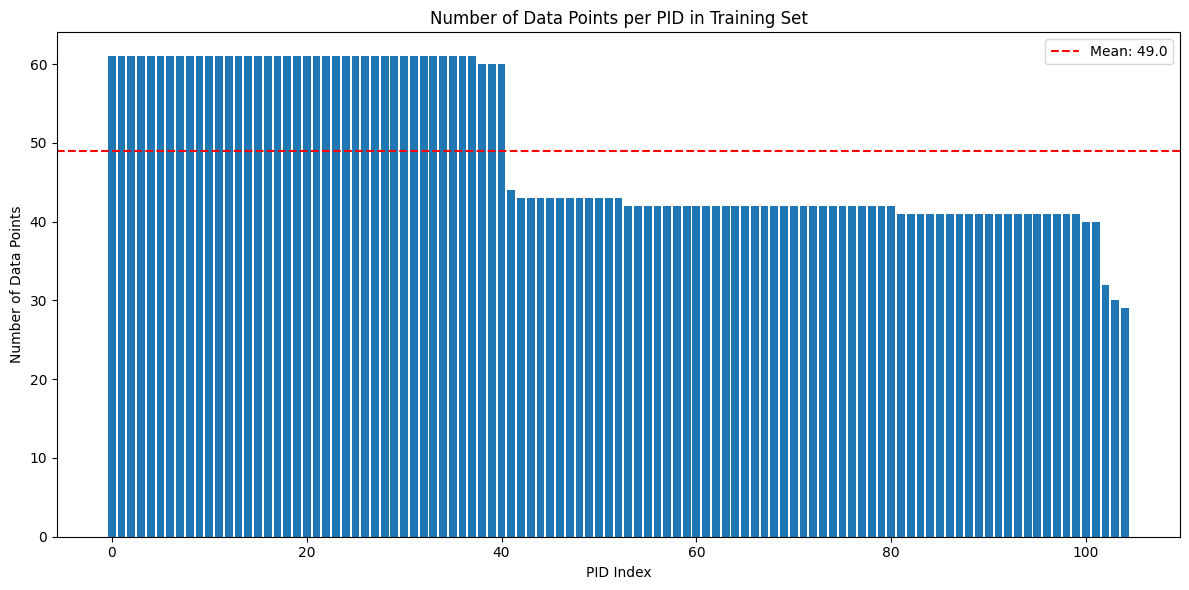

In [4]:
# Count data points per PID in training set
pid_counts = train_data['PID'].value_counts()

# Create bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pid_counts)), pid_counts.values)
plt.xlabel('PID Index')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points per PID in Training Set')

# Add mean line
mean_points = pid_counts.mean()
plt.axhline(y=mean_points, color='r', linestyle='--', label=f'Mean: {mean_points:.1f}')
plt.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [5]:
# Check for empty, binary (0/1) columns and non-numeric columns
empty_cols = []
binary_cols = []
non_numeric_cols = []

for col in train_data.columns:
    # Check if column is empty (all NaN)
    if train_data[col].isna().all():
        empty_cols.append(col)
        continue
        
    # Check if column is non-numeric
    if not np.issubdtype(train_data[col].dtype, np.number):
        non_numeric_cols.append(col)
        continue
        
    # Check if column only contains 0s and 1s
    unique_vals = train_data[col].unique()
    unique_vals = unique_vals[~np.isnan(unique_vals)]  # Remove NaN values
    if set(unique_vals).issubset({0, 1}):
        binary_cols.append(col)

print("Empty columns:")
print(empty_cols)
print("\nBinary columns:")
print(binary_cols)
print("\nNon-numeric columns:")
print(non_numeric_cols)


Empty columns:
[]

Binary columns:
['survey_complete', 'tasks_complete', 'watch_wearing', 'weekend', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'fe_lag_1_survey_complete', 'fe_lag_2_survey_complete', 'fe_lag_3_survey_complete', 'fe_lag_1_tasks_complete', 'fe_lag_2_tasks_complete', 'fe_lag_3_tasks_complete', 'fe_lag_1_watch_wearing', 'fe_lag_2_watch_wearing', 'fe_lag_3_watch_wearing']

Non-numeric columns:
['PID', 'trial_date', 'cohort']


# Functions

In [20]:
def expanding_window_cv_nested(df: pd.DataFrame, validation_days: int = 15) -> list[tuple[np.ndarray, np.ndarray]]:
    """
    Performs expanding window cross-validation accounting for nested observations within subjects.
    Creates 5 splits, each moving forward by 3 days and using 3 days for validation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Training data containing 'PID' and 'day' columns
    validation_days : int
        Number of days to use for validation windows
        
    Returns:
    --------
    list of tuples
        Each tuple contains (train_idx, val_idx) for one fold, 
        where indices from all subjects are combined
    """
    # Dictionary to store splits by window position
    window_splits = {}  # {window_position: [(train_idx, val_idx), ...]}
    
    # Process each subject separately
    for pid in df['PID'].unique():
        # Get data for this subject
        subject_data = df[df['PID'] == pid].copy()
        
        # Get sorted unique days for this subject
        subject_days = sorted(subject_data['day'].unique())
        n_days = len(subject_days)
        
        # Skip subjects with too few observations
        if n_days < 25:  # means min of 10 days in initial training
            continue
            
        # Determine window days for this subject
        window_start_idx = max(0, n_days - validation_days)
        window_days = subject_days[window_start_idx:]
        
        # Create 5 splits, moving forward by 3 days each time
        for window_pos in range(0, 5):  # 5 splits
            val_start_idx = window_start_idx + (window_pos * 3)  # Move forward by 3 days each time
            
            # Skip if we don't have enough days left
            if val_start_idx + 3 > len(subject_days):
                continue
                
            # Get 3 validation days
            val_days = subject_days[val_start_idx:val_start_idx + 3]
            
            # Get training days (all days up to validation period)
            train_days = subject_days[:val_start_idx]
            
            # Get indices for this split
            train_mask = (df['PID'] == pid) & (df['day'].isin(train_days))
            val_mask = (df['PID'] == pid) & (df['day'].isin(val_days))
            
            # Convert to indices
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only add split if we have both training and validation data
            if len(train_idx) > 0 and len(val_idx) > 0:
                # Add to window_splits dictionary
                if window_pos not in window_splits:
                    window_splits[window_pos] = []
                window_splits[window_pos].append((train_idx, val_idx))
    
    # Combine splits for each window position
    combined_splits = []
    for window_pos in sorted(window_splits.keys()):
        # Combine all train indices and all val indices for this window position
        all_train_idx = np.concatenate([split[0] for split in window_splits[window_pos]])
        all_val_idx = np.concatenate([split[1] for split in window_splits[window_pos]])
        combined_splits.append((all_train_idx, all_val_idx))
    
    return combined_splits

# Model Pipeline

In [89]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time
import warnings
#warnings.filterwarnings('ignore')

## Functions

### Feature Engineering and Scaling Functions

In [90]:
def prepare_data(df, features, target_col='target'):
    # X and y extraction
    X = df[features].values
    y = df[target_col].values
    return X, y

def fit_scaler(train_df, features):
    scaler = StandardScaler()
    scaler.fit(train_df[features])
    return scaler

def transform_data(df, scaler, features):
    X = scaler.transform(df[features])
    return X


### Categorical Threshold Functions

In [91]:
def compute_subject_thresholds(train_data, target_col='target'):
    """
    Compute per-subject thresholds for median and terciles.
    Returns dicts keyed by PID:
      median_thresholds[PID] = median_value
      tercile_thresholds[PID] = (lower_tercile_value, upper_tercile_value)
    """
    median_thresholds = {}
    tercile_thresholds = {}
    for pid, pid_df in train_data.groupby('PID'):
        vals = pid_df[target_col].values
        median_val = np.median(vals)
        # Terciles
        lower_tercile = np.percentile(vals, 66.66) # top tercile starts above this
        tercile_thresholds[pid] = lower_tercile
        median_thresholds[pid] = median_val
    return median_thresholds, tercile_thresholds

def apply_median_split(x, median_val):
    return 1 if x > median_val else 0

def apply_tercile_split(x, tercile_val):
    # top tercile is > tercile_val
    return 1 if x > tercile_val else 0

def create_categorical_labels(df, median_thresh, tercile_thresh, target_col='target'):
    df = df.copy()
    
   # 1. Median split label
    df.loc[:, 'median_label'] = df.apply(
        lambda row: apply_median_split(row[target_col], median_thresh[row['PID']]), 
        axis=1
    )
    # 2. Tercile split label
    df.loc[:, 'tercile_label'] = df.apply(
        lambda row: apply_tercile_split(row[target_col], tercile_thresh[row['PID']]), 
        axis=1
    )
    
    return df

def create_change_labels(df, target_col='target', median_thresh=None, tercile_thresh=None):
    # Create a copy of the dataframe to avoid the warning
    df = df.copy()
    
    # For each PID, sort by day and create various labels
    def pid_change_labels(pid_df):
        # Create a copy of the group dataframe
        pid_df = pid_df.copy()
        pid_df = pid_df.sort_values('day')
        vals = pid_df[target_col].values
        
        # median low-high change
        if median_thresh is not None:
            med = median_thresh[pid_df['PID'].iloc[0]]
            low_high = (vals > med).astype(int)
            # low to high change: current=1, previous=0
            pid_df.loc[:, 'median_low_high_change'] = np.insert(
                (low_high[1:] == 1) & (low_high[:-1] == 0), 
                0, 
                False
            ).astype(int)
        else:
            pid_df.loc[:, 'median_low_high_change'] = np.nan
        
        # tercile low-high change
        if tercile_thresh is not None:
            t_val = tercile_thresh[pid_df['PID'].iloc[0]]
            low_high_terc = (vals > t_val).astype(int)
            pid_df.loc[:, 'tercile_low_high_change'] = np.insert(
                (low_high_terc[1:] == 1) & (low_high_terc[:-1] == 0), 
                0, 
                False
            ).astype(int)
        else:
            pid_df.loc[:, 'tercile_low_high_change'] = np.nan
        
        # daily change direction
        diff = np.insert(np.diff(vals), 0, 0)
        pid_df.loc[:, 'daily_change_direction'] = (diff > 0).astype(int)
        
        # large increase (>=1 SD)
        std_val = np.std(vals)
        large_inc = np.insert((np.diff(vals) >= std_val), 0, False).astype(int)
        pid_df.loc[:, 'large_increase'] = large_inc
        
        return pid_df
    
    df = df.groupby('PID', group_keys=False).apply(pid_change_labels)
    return df

### Evaluation Functions

In [92]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

def classification_metrics(y_true, y_pred):
    # y_pred are class labels
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return acc, prec, rec, f1

### Standard ML Model Functions

In [93]:
def train_regression_model(X_train, y_train, model_type='linear'):
    if model_type == 'linear':
        model = LinearRegression()
    elif model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'xgb':
        model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Unknown model type")
    model.fit(X_train, y_train)
    return model

def train_classification_model(X_train, y_train, model_type='logistic'):
    if model_type == 'logistic':
        model = LogisticRegression()
    elif model_type == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'xgb':
        model = xgb.XGBClassifier(n_estimators=100, random_state=42)
    else:
        raise ValueError("Unknown model type")
    model.fit(X_train, y_train)
    return model

### Deep Learning Model Functions

In [36]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=7):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.X) - self.seq_len
    
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def train_lstm_model(X_train, y_train, input_size, seq_len=7, epochs=10):
    dataset = TimeSeriesDataset(X_train, y_train, seq_len=seq_len)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = LSTMModel(input_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        for Xb, yb in loader:
            Xb = Xb.float()
            yb = yb.float().unsqueeze(1)
            optimizer.zero_grad()
            pred = model(Xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()
    return model

# For a transformer or classification with neural nets, you’d define a similar class and training routine

### Prediction and Evaluation at Group-Level, Individual-Level, and Combined

In [37]:
def make_predictions(model, X):
    if hasattr(model, 'predict'):
        return model.predict(X)
    else:
        # For PyTorch models
        model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            return model(X_t).numpy().ravel()

### Main Pipeline

In [100]:
def evaluate_predictions(y_true, y_pred, y_cat, thresh_dict, pid_series):
    """
    Evaluate predictions across all metrics
    Returns dict with all evaluation metrics
    """
    results = {}
    
    # Regression metrics
    mae, rmse = regression_metrics(y_true, y_pred)
    results.update({'mae': mae, 'rmse': rmse})
    
    # Convert continuous predictions to binary for classification metrics
    # 1. Median split
    med_pred = np.array([apply_median_split(pred, thresh_dict['median'][pid]) 
                        for pred, pid in zip(y_pred, pid_series)])
    med_true = np.array([apply_median_split(true, thresh_dict['median'][pid]) 
                        for true, pid in zip(y_true, pid_series)])
    acc, prec, rec, f1 = classification_metrics(med_true, med_pred)
    results.update({
        'median_accuracy': acc,
        'median_precision': prec,
        'median_recall': rec,
        'median_f1': f1
    })
    
    # 2. Tercile split
    terc_pred = np.array([apply_tercile_split(pred, thresh_dict['tercile'][pid]) 
                         for pred, pid in zip(y_pred, pid_series)])
    terc_true = np.array([apply_tercile_split(true, thresh_dict['tercile'][pid]) 
                         for true, pid in zip(y_true, pid_series)])
    acc, prec, rec, f1 = classification_metrics(terc_true, terc_pred)
    results.update({
        'tercile_accuracy': acc,
        'tercile_precision': prec,
        'tercile_recall': rec,
        'tercile_f1': f1
    })
    
    # 3. Direct classification metrics (if y_cat provided)
    if y_cat is not None:
        for cat in ['median_label', 'tercile_label', 'median_low_high_change',
                   'tercile_low_high_change', 'daily_change_direction', 'large_increase']:
            if cat in y_cat:
                # For regression models, convert continuous predictions to binary
                if not np.all(np.isin(y_pred, [0, 1])):
                    # Use 0.5 as threshold for converting continuous predictions to binary
                    binary_preds = (y_pred > 0.5).astype(int)
                else:
                    binary_preds = y_pred
                    
                acc, prec, rec, f1 = classification_metrics(y_cat[cat].values, binary_preds)
                results.update({
                    f'{cat}_accuracy': acc,
                    f'{cat}_precision': prec,
                    f'{cat}_recall': rec,
                    f'{cat}_f1': f1
                })
    
    return results

def prepare_features(train_data, test_data, features):
    """
    Prepare features by handling missing values and scaling.
    Uses forward fill followed by backward fill for missing values.
    """
    # Create copy of data to avoid modifying original
    train_features = train_data[features + ['PID']].copy()
    test_features = test_data[features + ['PID']].copy()
    
    # 1. Handle missing values
    # First forward fill within each PID group
    for col in features:  # Only process feature columns, not PID
        train_features[col] = train_features.groupby('PID')[col].ffill()
        test_features[col] = test_features.groupby('PID')[col].ffill()
        
        # Then backward fill for any remaining NaNs
        train_features[col] = train_features.groupby('PID')[col].bfill()
        test_features[col] = test_features.groupby('PID')[col].bfill()
    
    # If there are still any NaNs (e.g., if entire column is NaN for a subject),
    # fill with 0 as last resort
    train_features[features] = train_features[features].fillna(0)
    test_features[features] = test_features[features].fillna(0)
    
    # 2. Scale features
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_features[features])
    test_scaled = scaler.transform(test_features[features])
    
    return train_scaled, test_scaled, scaler

def main_pipeline(train_data_clean, test_data_clean, features, cv_folds, target_col='target'):
    """
    Main pipeline incorporating CV and multiple models with timing measurements
    
    Parameters:
    -----------
    train_data_clean : pd.DataFrame
        Training data with features and target
    test_data_clean : pd.DataFrame
        Test data with features and target
    features : list
        List of feature column names
    cv_folds : list
        List of (train_idx, val_idx) tuples for cross-validation
    target_col : str
        Name of target column
        
    Returns:
    --------
    results_df : pd.DataFrame
        DataFrame containing model performance metrics
    timing_df : pd.DataFrame
        DataFrame containing timing information for model fitting and prediction
    """
    # Initialize results and timing stats
    results = []
    timing_stats = {
        'model_type': [],
        'model_name': [], 
        'level': [],
        'fold': [],
        'fit_time': [],
        'predict_time': []
    }
    
    # Compute thresholds
    thresh_dict = {
        'median': compute_subject_thresholds(train_data_clean, target_col)[0],
        'tercile': compute_subject_thresholds(train_data_clean, target_col)[1]
    }
    
    # Create categorical labels
    train_data_clean = create_categorical_labels(train_data_clean, 
                                               thresh_dict['median'],
                                               thresh_dict['tercile'],
                                               target_col)
    train_data_clean = create_change_labels(train_data_clean, target_col,
                                          thresh_dict['median'],
                                          thresh_dict['tercile'])
    
    # Model configurations
    reg_models = {
        'linear': 'linear',
        'rf_reg': 'rf',
        'xgb_reg': 'xgb'
    }
    
    clf_models = {
        'logistic': 'logistic',
        'rf_clf': 'rf',
        'xgb_clf': 'xgb'
    }
    
    # Cross validation loop
    for fold_idx, (train_idx, val_idx) in enumerate(cv_folds):
        print(f"Processing fold {fold_idx+1}/{len(cv_folds)}")
        
        # Split data
        train_fold = train_data_clean.iloc[train_idx]
        val_fold = train_data_clean.iloc[val_idx]
        
        # Prepare features
        prep_start = time.time()
        X_train_scaled, X_val_scaled, scaler = prepare_features(
            train_fold, val_fold, features
        )
        prep_time = time.time() - prep_start
        print(f"Feature preparation time: {prep_time:.2f} seconds")
        
        y_train = train_fold[target_col].values
        y_val = val_fold[target_col].values
        val_pids = val_fold['PID']
        
        # 1. Regression Models
        for model_name, model_type in reg_models.items():
            print(f"\nProcessing regression model: {model_name}")
            
            # Group level
            start_time = time.time()
            group_model = train_regression_model(X_train_scaled, y_train, model_type)
            fit_time = time.time() - start_time
            
            start_time = time.time()
            group_preds = group_model.predict(X_val_scaled)
            predict_time = time.time() - start_time
            
            # Record group-level timing
            timing_stats['model_type'].append('regression')
            timing_stats['model_name'].append(model_name)
            timing_stats['level'].append('group')
            timing_stats['fold'].append(fold_idx)
            timing_stats['fit_time'].append(fit_time)
            timing_stats['predict_time'].append(predict_time)
            
            # Individual level
            ind_fit_times = []
            ind_predict_times = []
            ind_preds = np.zeros_like(y_val)
            
            for pid in val_pids.unique():
                pid_train_mask = (train_fold['PID'] == pid)
                if pid_train_mask.sum() > 10:  # Only train if enough data
                    # Prepare features for this individual
                    pid_train = train_fold[pid_train_mask]
                    pid_val = val_fold[val_pids == pid]
                    
                    X_pid_train, X_pid_val, _ = prepare_features(
                        pid_train, pid_val, features
                    )
                    
                    # Train and time individual model
                    start_time = time.time()
                    pid_model = train_regression_model(
                        X_pid_train, 
                        pid_train[target_col].values,
                        model_type
                    )
                    ind_fit_times.append(time.time() - start_time)
                    
                    # Predict and time
                    start_time = time.time()
                    pid_val_mask = (val_pids == pid)
                    ind_preds[pid_val_mask] = pid_model.predict(X_pid_val)
                    ind_predict_times.append(time.time() - start_time)
                else:
                    # Use group predictions if not enough individual data
                    pid_val_mask = (val_pids == pid)
                    ind_preds[pid_val_mask] = group_preds[pid_val_mask]
            
            # Record average individual-level timing
            if ind_fit_times:
                timing_stats['model_type'].append('regression')
                timing_stats['model_name'].append(model_name)
                timing_stats['level'].append('individual')
                timing_stats['fold'].append(fold_idx)
                timing_stats['fit_time'].append(np.mean(ind_fit_times))
                timing_stats['predict_time'].append(np.mean(ind_predict_times))
            
            # Combined predictions
            combined_preds = 0.5 * (group_preds + ind_preds)
            
            # Evaluate all prediction types
            for pred_type, preds in [('group', group_preds), 
                                   ('individual', ind_preds),
                                   ('combined', combined_preds)]:
                eval_results = evaluate_predictions(
                    y_val,
                    preds,
                    val_fold[['median_label', 'tercile_label',
                             'median_low_high_change', 'tercile_low_high_change',
                             'daily_change_direction', 'large_increase']],
                    thresh_dict,
                    val_pids
                )
                
                results.append({
                    'fold': fold_idx,
                    'model': model_name,
                    'type': 'regression',
                    'level': pred_type,
                    **eval_results
                })
        
        # 2. Classification Models
        for model_name, model_type in clf_models.items():
            print(f"\nProcessing classification model: {model_name}")
            
            for target in ['median_label', 'tercile_label', 'median_low_high_change',
                         'tercile_low_high_change', 'daily_change_direction', 'large_increase']:
                
                y_train_cat = train_fold[target]
                y_val_cat = val_fold[target]
                
                # Group level
                start_time = time.time()
                group_model = train_classification_model(X_train_scaled, y_train_cat, model_type)
                fit_time = time.time() - start_time
                
                start_time = time.time()
                group_preds = group_model.predict(X_val_scaled)
                predict_time = time.time() - start_time
                
                # Record group-level timing
                timing_stats['model_type'].append('classification')
                timing_stats['model_name'].append(f"{model_name}_{target}")
                timing_stats['level'].append('group')
                timing_stats['fold'].append(fold_idx)
                timing_stats['fit_time'].append(fit_time)
                timing_stats['predict_time'].append(predict_time)
                
                # Individual level
                ind_fit_times = []
                ind_predict_times = []
                ind_preds = np.zeros_like(y_val_cat)
                
                for pid in val_pids.unique():
                    pid_train_mask = (train_fold['PID'] == pid)
                    if pid_train_mask.sum() > 10:
                        pid_train = train_fold[pid_train_mask]
                        pid_val = val_fold[val_pids == pid]
                        
                        X_pid_train, X_pid_val, _ = prepare_features(
                            pid_train, pid_val, features
                        )
                        
                        start_time = time.time()
                        pid_model = train_classification_model(
                            X_pid_train,
                            pid_train[target].values,
                            model_type
                        )
                        ind_fit_times.append(time.time() - start_time)
                        
                        start_time = time.time()
                        pid_val_mask = (val_pids == pid)
                        ind_preds[pid_val_mask] = pid_model.predict(X_pid_val)
                        ind_predict_times.append(time.time() - start_time)
                    else:
                        pid_val_mask = (val_pids == pid)
                        ind_preds[pid_val_mask] = group_preds[pid_val_mask]
                
                # Record average individual-level timing
                if ind_fit_times:
                    timing_stats['model_type'].append('classification')
                    timing_stats['model_name'].append(f"{model_name}_{target}")
                    timing_stats['level'].append('individual')
                    timing_stats['fold'].append(fold_idx)
                    timing_stats['fit_time'].append(np.mean(ind_fit_times))
                    timing_stats['predict_time'].append(np.mean(ind_predict_times))
                
                # Combined predictions
                combined_preds = (0.5 * (group_preds + ind_preds) > 0.5).astype(int)
                
                # Evaluate all prediction types
                for pred_type, preds in [('group', group_preds),
                                       ('individual', ind_preds),
                                       ('combined', combined_preds)]:
                    acc, prec, rec, f1 = classification_metrics(y_val_cat, preds)
                    results.append({
                        'fold': fold_idx,
                        'model': model_name,
                        'type': 'classification',
                        'target': target,
                        'level': pred_type,
                        'mae': np.nan,
                        'rmse': np.nan,
                        'median_accuracy': acc,
                        'median_precision': prec,
                        'median_recall': rec,
                        'median_f1': f1,
                        'tercile_accuracy': np.nan,
                        'tercile_precision': np.nan,
                        'tercile_recall': np.nan,
                        'tercile_f1': np.nan,
                        'median_low_high_change_accuracy': np.nan,
                        'median_low_high_change_precision': np.nan,
                        'median_low_high_change_recall': np.nan,
                        'median_low_high_change_f1': np.nan,
                        'tercile_low_high_change_accuracy': np.nan,
                        'tercile_low_high_change_precision': np.nan,
                        'tercile_low_high_change_recall': np.nan,
                        'tercile_low_high_change_f1': np.nan,
                        'daily_change_direction_accuracy': np.nan,
                        'daily_change_direction_precision': np.nan,
                        'daily_change_direction_recall': np.nan,
                        'daily_change_direction_f1': np.nan,
                        'large_increase_accuracy': np.nan,
                        'large_increase_precision': np.nan,
                        'large_increase_recall': np.nan,
                        'large_increase_f1': np.nan,
                    })
                    
                    # Update the specific target's metrics
                    results[-1][f'{target}_accuracy'] = acc
                    results[-1][f'{target}_precision'] = prec
                    results[-1][f'{target}_recall'] = rec
                    results[-1][f'{target}_f1'] = f1
    
    # Convert results and timing to DataFrames
    results_df = pd.DataFrame(results)
    timing_df = pd.DataFrame(timing_stats)
    
    return results_df, timing_df

## Clean Data

In [101]:
# Drop rows with missing values in t_current
train_data_clean = train_data.dropna(subset=['t_current'])
test_data_clean = test_data.dropna(subset=['t_current'])

In [102]:
# Create CV folds
cv_folds = expanding_window_cv_nested(train_data_clean)

## Select Features

In [103]:
# Filter features from mlm_gap_df where abs_t_value > 2 and exclude 'css' features
features = [f for f in mlm_gap_df[mlm_gap_df['abs_t_value'] > 2]['feature'].tolist() 
                       if 'css' not in f]

print(f"Selected {len(features)} features with |t| > 2 (excluding css features):")

Selected 65 features with |t| > 2 (excluding css features):


## Run Model Pipeline

- Figure out which parts of the pipeline are taking the most time
- Figure out how this is actually scoring the folds and what is being used to determine the numbers in the results
- How are the predictions being made? What model is being used?
- Is it selecting a best model? If so, how is it doing this?
- How to determine underfitting vs. overfitting with some sort of metric and/or visualizations?
- Add hyperparameter tuning with optuna

In [104]:
# Run the pipeline
results_df, timing_df = main_pipeline(train_data_clean, test_data_clean, features, cv_folds, target_col='t_current')

# # Save results
# results_df.to_csv('model_evaluation_results.csv', index=False)

Processing fold 1/5
Feature preparation time: 0.08 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 2/5
Feature preparation time: 0.08 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 3/5
Feature preparation time: 0.09 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 4/5
Feature preparation time: 0.08 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 5/5
Feature preparation time: 0.09 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf


In [ ]:
# Print timing summary
print("\nTiming Summary:")
summary = timing_df.groupby(['model_type', 'model_name', 'level']).agg({
    'fit_time': ['mean', 'std'],
    'predict_time': ['mean', 'std']
}).round(3)
print(summary)

In [99]:
# Create timing visualization
plt.figure(figsize=(15, 6))
sns.boxplot(data=timing_df, x='model_name', y='fit_time', hue='level')
plt.title('Model Fitting Times by Model Type and Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create separate plots for regression and classification models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Regression models
reg_timing = timing_df[timing_df['model_type'] == 'regression']
sns.boxplot(data=reg_timing, x='model_name', y='fit_time', hue='level', ax=ax1)
ax1.set_title('Regression Models Fitting Times')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Classification models
clf_timing = timing_df[timing_df['model_type'] == 'classification']
sns.boxplot(data=clf_timing, x='model_name', y='fit_time', hue='level', ax=ax2)
ax2.set_title('Classification Models Fitting Times')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'timing_df' is not defined

<Figure size 1500x600 with 0 Axes>

In [109]:
results_df

,fold,model,type,level,mae,rmse,median_accuracy,median_precision,median_recall,median_f1,...,tercile_low_high_change_f1,daily_change_direction_accuracy,daily_change_direction_precision,daily_change_direction_recall,daily_change_direction_f1,large_increase_accuracy,large_increase_precision,large_increase_recall,large_increase_f1,target
0,0,linear,regression,group,15.618123,19.801684,0.532051,0.507143,0.479730,0.493056,...,0.318059,0.474359,0.474359,1.000000,0.643478,0.195513,0.195513,1.000000,0.327078,NaN
1,0,linear,regression,individual,81.907273,254.039855,0.455128,0.440860,0.554054,0.491018,...,0.306785,0.455128,0.460714,0.871622,0.602804,0.253205,0.192857,0.885246,0.316716,NaN
2,0,linear,regression,combined,45.333302,129.058048,0.464744,0.445087,0.520270,0.479751,...,0.316667,0.451923,0.461794,0.939189,0.619154,0.211538,0.192691,0.950820,0.320442,NaN
3,0,rf_reg,regression,group,13.942583,17.952240,0.535256,0.510791,0.479730,0.494774,...,0.318059,0.474359,0.474359,1.000000,0.643478,0.195513,0.195513,1.000000,0.327078,NaN
4,0,rf_reg,regression,individual,13.132591,16.942252,0.493590,0.470238,0.533784,0.500000,...,0.318059,0.474359,0.474359,1.000000,0.643478,0.195513,0.195513,1.000000,0.327078,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,4,xgb_clf,classification,individual,NaN,NaN,0.503205,0.484472,0.520000,0.501608,...,NaN,0.503205,0.484472,0.520000,0.501608,NaN,NaN,NaN,NaN,daily_change_direction
311,4,xgb_clf,classification,combined,NaN,NaN,0.551282,0.559524,0.313333,0.401709,...,NaN,0.551282,0.559524,0.313333,0.401709,NaN,NaN,NaN,NaN,daily_change_direction
312,4,xgb_clf,classification,group,NaN,NaN,0.791667,0.214286,0.052632,0.084507,...,NaN,NaN,NaN,NaN,NaN,0.791667,0.214286,0.052632,0.084507,large_increase
313,4,xgb_clf,classification,individual,NaN,NaN,0.733974,0.229167,0.192982,0.209524,...,NaN,NaN,NaN,NaN,NaN,0.733974,0.229167,0.192982,0.209524,large_increase


In [83]:
results_df.head(20)

,fold,model,type,level,mae,rmse,median_accuracy,median_precision,median_recall,median_f1,...,daily_change_direction_f1,large_increase_accuracy,large_increase_precision,large_increase_recall,large_increase_f1,target,accuracy,precision,recall,f1
0,0,linear,regression,group,15.618123,19.801684,0.532051,0.507143,0.479730,0.493056,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
1,0,linear,regression,individual,81.907273,254.039855,0.455128,0.440860,0.554054,0.491018,...,0.602804,0.253205,0.192857,0.885246,0.316716,NaN,NaN,NaN,NaN,NaN
2,0,linear,regression,combined,45.333302,129.058048,0.464744,0.445087,0.520270,0.479751,...,0.619154,0.211538,0.192691,0.950820,0.320442,NaN,NaN,NaN,NaN,NaN
3,0,rf_reg,regression,group,13.942583,17.952240,0.535256,0.510791,0.479730,0.494774,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
4,0,rf_reg,regression,individual,13.132591,16.942252,0.493590,0.470238,0.533784,0.500000,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
5,0,rf_reg,regression,combined,13.005914,16.705597,0.496795,0.471338,0.500000,0.485246,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
6,0,xgb_reg,regression,group,14.520377,18.717502,0.551282,0.525000,0.567568,0.545455,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
7,0,xgb_reg,regression,individual,14.933582,19.392818,0.525641,0.500000,0.520270,0.509934,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
8,0,xgb_reg,regression,combined,13.601211,17.239493,0.500000,0.474684,0.506757,0.490196,...,0.643478,0.195513,0.195513,1.000000,0.327078,NaN,NaN,NaN,NaN,NaN
9,0,logistic,classification,group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,median_label,0.528846,0.503448,0.493243,0.498294


In [105]:
import cProfile

cProfile.run("main_pipeline(train_data_clean, test_data_clean, features, cv_folds, target_col='t_current')")

Processing fold 1/5
Feature preparation time: 0.13 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 2/5
Feature preparation time: 0.14 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 3/5
Feature preparation time: 0.15 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 4/5
Feature preparation time: 0.16 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
Processing fold 5/5
Feature preparation time: 0.16 seconds

Processing regression model: linear

Processing regression model: rf_reg

Processing regression model: xgb_reg

Processing classification model: logistic


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown


Processing classification model: rf_clf

Processing classification model: xgb_clf
         3655194567 function calls (3596620060 primitive calls) in 1694.947 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1575    0.010    0.000  150.031    0.095 104062838.py:1(train_regression_model)
     9450    0.040    0.000  393.666    0.042 104062838.py:13(train_classification_model)
       45    0.000    0.000    0.022    0.000 1045018668.py:1(regression_metrics)
      630    0.003    0.000    2.657    0.004 1045018668.py:6(classification_metrics)
       45    0.003    0.000    1.449    0.032 1287090067.py:1(evaluate_predictions)
       45    0.003    0.000    0.004    0.000 1287090067.py:14(<listcomp>)
       45    0.003    0.000    0.004    0.000 1287090067.py:16(<listcomp>)
       45    0.003    0.000    0.004    0.000 1287090067.py:27(<listcomp>)
       45    0.003    0.000    0.004    0.000 1287090067.py:29(<listcomp>)
   

In [107]:
(1114/60) / (1694/60)

0.6576151121605667